# Loading and working with GeoMIP (G6sulfur) data directly from ESGF

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
#from utils import weighted_seasonal_resample, weighted_annual_resample, calc_weighted_spatial_means
import warnings
warnings.filterwarnings("ignore", module='xarray') # not great practice, but xarray tends to give lots of verbose warnings

# user inputs
scenarios = ['ssp245', 'ssp585', 'G6sulfur']


# time-periods over which to take means
assessment_periods = {'Future':slice('2080', '2099'),
                      'Baseline':slice('2015', '2034')}


In [4]:
# on starting the server, we need to run the line below once, as intake_esgf is not yet in our standard pangeo environment
# but it can be commented out after this, to save time
%pip install intake_esgf

In [17]:
import intake_esgf

In [18]:
intake_esgf.conf.set(all_indices=True)
cat = intake_esgf.ESGFCatalog()

In [28]:
cat.search(
    project='CMIP6',
    experiment_id=scenarios,
    source_id='UKESM1-0-LL',
    variable_id='tas',  # surface air temperature
    table_id='Amon',    # monthly atmospheric data
    variant_label=['r1i1p1f2']  # ensemble member
)

   Searching indices:   0%|          |0/9 [       ?index/s]

Summary information for 3 results:
mip_era                              [CMIP6]
activity_drs           [ScenarioMIP, GeoMIP]
institution_id                        [MOHC]
source_id                      [UKESM1-0-LL]
experiment_id     [ssp245, ssp585, G6sulfur]
member_id                         [r1i1p1f2]
table_id                              [Amon]
variable_id                            [tas]
grid_label                              [gn]
dtype: object

In [29]:
dsd = cat.to_dataset_dict(add_measures=True)

Get file information:   0%|          |0/9 [       ?index/s]

tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_...:   0%|          |0.00/38.4M [?B/s]

tas_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_...:   0%|          |0.00/27.8M [?B/s]

tas_Amon_UKESM1-0-LL_ssp245_r1i1p1f2_...:   0%|          |0.00/38.5M [?B/s]

tas_Amon_UKESM1-0-LL_ssp245_r1i1p1f2_...:   0%|          |0.00/27.8M [?B/s]

Adding cell measures:   0%|          |0/3 [     ?dataset/s]

{'ScenarioMIP.ssp245': <xarray.Dataset> Size: 120MB
 Dimensions:    (time: 1032, bnds: 2, lat: 144, lon: 192)
 Coordinates:
   * time       (time) object 8kB 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
   * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
   * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
     height     float64 8B 1.5
 Dimensions without coordinates: bnds
 Data variables:
     time_bnds  (time, bnds) object 17kB dask.array<chunksize=(1, 2), meta=np.ndarray>
     lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(420, 144, 2), meta=np.ndarray>
     lon_bnds   (time, lon, bnds) float64 3MB dask.array<chunksize=(420, 192, 2), meta=np.ndarray>
     tas        (time, lat, lon) float32 114MB dask.array<chunksize=(1, 144, 192), meta=np.ndarray>
     areacella  (lat, lon) float32 111kB ...
 Attributes: (12/48)
     Conventions:            CF-1.7 CMIP-6.2
     activity_id:            ScenarioMIP
     branch_metho

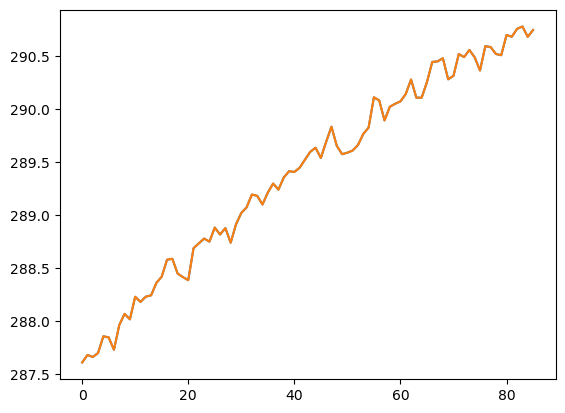

In [42]:
plt.plot(global_mean(dsd['ScenarioMIP.ssp245'], 'tas').resample(time='AS').mean().tas)


In [41]:
## example usage, lets plot the global spatial mean timeseries under the three scenarios:

# first, define a function to get the global mean, accounting for area weights (areacella)
def global_mean(ds, variable):
    weights = ds['areacella']
    data = ds[variable]
    
    # Normalize weights to sum to 1
    weights_normalized = weights / weights.sum()
    
    # Apply weighted mean
    global_mean = (data * weights_normalized).sum(dim=['lat', 'lon'])
    
    return global_mean.to_dataset(name=variable)
    
# second, define a function to resample to annual resolution
# note, in general we have to account for different month lengths
def weighted_annual_resample(ds):
    """
    weight by days in each month
    adapted from NCAR docs 
    https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    numerator = (ds * wgts).resample(time="YS").sum(dim="time")
    denominator = wgts.resample(time="YS").sum(dim="time")

    return numerator/denominator

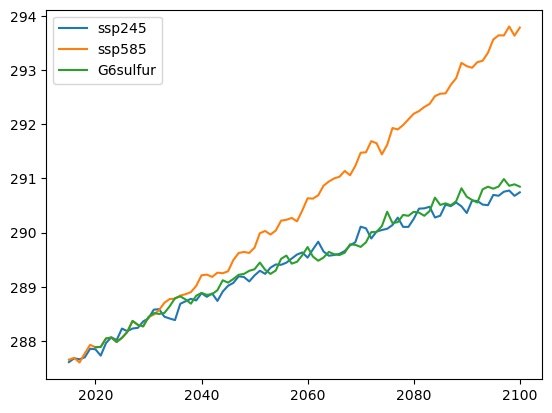

In [48]:
# make a quick plot:

for scenario in ['ScenarioMIP.ssp245', 'ScenarioMIP.ssp585', 'GeoMIP.G6sulfur']:
    data = weighted_annual_resample(global_mean(dsd[scenario], 'tas'))
    plt.plot(data.time.dt.year, data.tas, label=scenario.split('.')[1])
plt.legend()